In [1]:
%matplotlib inline


# Faces recognition example using eigenfaces and SVMs


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)


Expected results for the top 5 most represented people in the dataset:

================== ============ ======= ========== =======
                   precision    recall  f1-score   support
================== ============ ======= ========== =======
     Ariel Sharon       0.67      0.92      0.77        13
     Colin Powell       0.75      0.78      0.76        60
  Donald Rumsfeld       0.78      0.67      0.72        27
    George W Bush       0.86      0.86      0.86       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.67      0.67      0.67        15
       Tony Blair       0.81      0.69      0.75        36

      avg / total       0.80      0.80      0.80       322
================== ============ ======= ========== =======




In [2]:




from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC



lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]


y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]












In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [4]:
n_components = 150

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)


eigenfaces = pca.components_.reshape((n_components, h, w))


X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [5]:

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0005)


In [6]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.018s
                   precision    recall  f1-score   support

  Donald Rumsfeld       0.83      0.83      0.83        36
    George W Bush       0.91      0.98      0.94       123
Gerhard Schroeder       1.00      0.71      0.83        31

         accuracy                           0.91       190
        macro avg       0.91      0.84      0.87       190
     weighted avg       0.91      0.91      0.90       190

[[ 30   6   0]
 [  3 120   0]
 [  3   6  22]]


In [7]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 7.960s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0005)


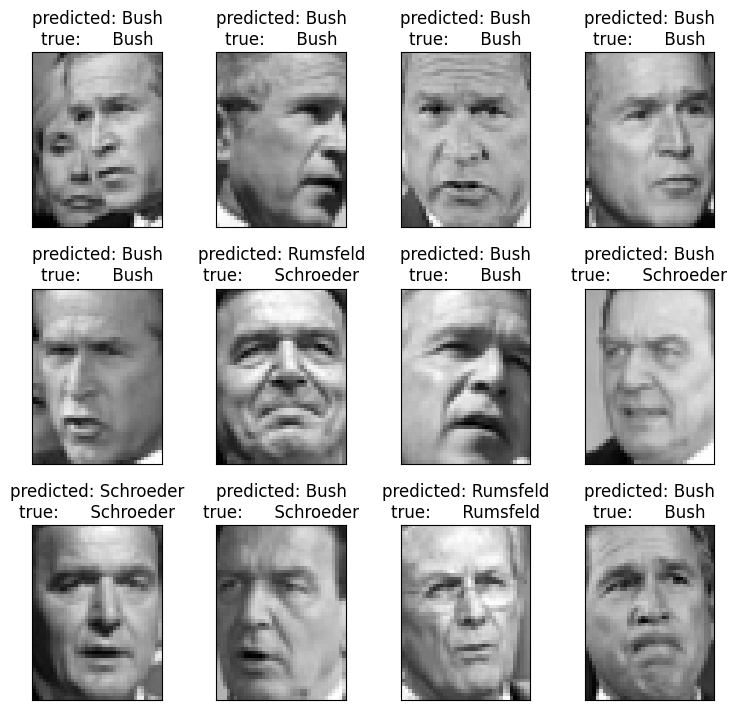

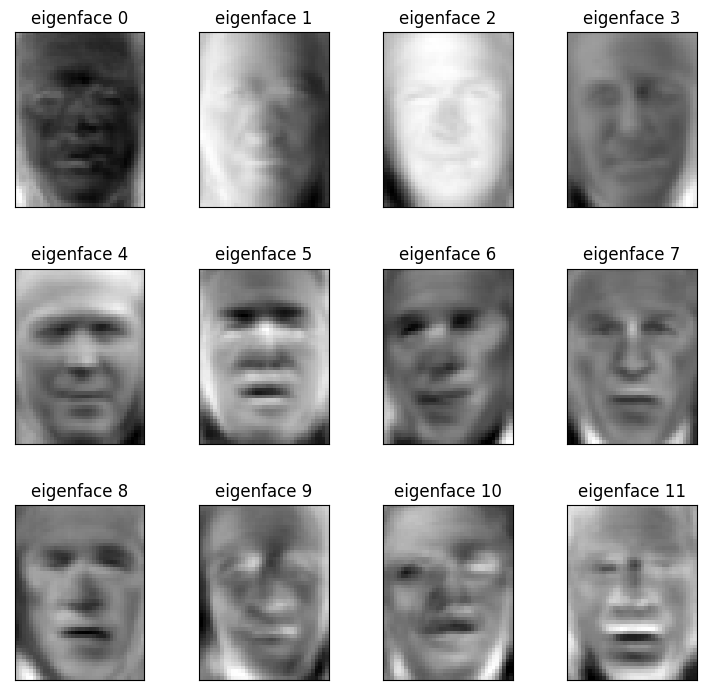

In [8]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

clf = GaussianNB()


clf.fit(X_train_pca, y_train)  


y_pred = clf.predict(X_test_pca)  


print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.44      0.51        36
           1       0.81      0.93      0.87       123
           2       0.90      0.61      0.73        31

    accuracy                           0.79       190
   macro avg       0.77      0.66      0.70       190
weighted avg       0.78      0.79      0.78       190

[[ 16  18   2]
 [  8 115   0]
 [  3   9  19]]


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = RandomForestClassifier()

clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.03      0.05        36
           1       0.65      1.00      0.79       123
           2       1.00      0.03      0.06        31

    accuracy                           0.66       190
   macro avg       0.88      0.35      0.30       190
weighted avg       0.78      0.66      0.53       190

[[  1  35   0]
 [  0 123   0]
 [  0  30   1]]


In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf = KNeighborsClassifier(n_neighbors=n_classes)

clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.75      0.25      0.38        36
           1       0.72      1.00      0.83       123
           2       1.00      0.19      0.32        31

    accuracy                           0.73       190
   macro avg       0.82      0.48      0.51       190
weighted avg       0.77      0.73      0.66       190

[[  9  27   0]
 [  0 123   0]
 [  3  22   6]]


In [13]:
y_train

array([2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 2, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 2,
       1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2, 1, 1,
       0, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       0, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1,